# Tutorial 1: Collect and Clean Twitter Data

## Introduction

In this tutorial you will:

-  Use the Twitter API to collect COVID19-related Twitter data
-  Extract the tweet text and any metadata you require
-  Perform preprocessing of the text to allow for better application of NLP techniques.

### Let's get started!

To access the Twitter API, we will make use of the Python library **_Tweepy_**. Let's start by importing tweepy and other libraries needed for this tutorial.

In [ ]:
# ___Cell no. 1___

import tweepy
import pandas as pd
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud
import nltk 
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")

<hr>

## Section 1: Data Collection

In order to access the Twitter API so that you can collect Twitter data, you will need to enter your user credentials into the existing **twitter_credentials.py** file. You can find this file on the Jupyter home page - click on it to edit, then copy and paste in your credentials and save the changes. 

In [ ]:
# ___Cell no. 2___

# We then import the credentials
import twitter_credentials as tc

Next, we authenticate using our API keys and tokens as follows:

In [ ]:
# ___Cell no. 3___

# Create an authentication object of the AuthHandler class by passing in the credentials
auth = tweepy.OAuthHandler(tc.api_key, tc.api_secret_key)

# Set the access tokens to complete the authentication process
auth.set_access_token(tc.access_token, tc.access_token_secret)

We then create the API object while passing in the authentication information

In [ ]:
# ___Cell no. 4___

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In the above line of code we also ensure that if we are rate limited by the Twitter api while submitting queries, we will wait until the rate limit time has lapsed and then continue to collect data.

We are now ready to build a Standard API search query. You can find more information on search rules and filtering for standard Twitter API searches [here](https://developer.twitter.com/en/docs/tweets/rules-and-filtering/overview/standard-operators).

In [ ]:
# ___Cell no. 5___

# Enter your search words in accordance with the basic filtering rules
search_words = "coronavirus OR covid OR pandemic OR covid19 OR lockdown"

# We also want to exclude retweets and replies as this may sway results
my_search = search_words + " -filter:retweets" + " -filter:replies"  

Below is a simple API search where we filter tweets based on our chosen search words and the language, which is chosen to be English in this case (Twitter supports 34 different languages). The extended tweet mode allows us to load the full text of the tweet which is otherwise truncated.

In [ ]:
# ___Cell no. 6___

# The Twitter data is stored in a Tweet object which we've called tweets
tweets = api.search(q=my_search,lang="en",tweet_mode="extended",count=100)

Now let's print the text of the first 20 tweets to see if our query is working correctly.

In [ ]:
# ___Cell no. 7___

# Iterate and print tweets
i = 1
for tweet in tweets[0:20]:
    print(str(i) + ') ' + tweet.full_text + '\n')
    i = i + 1 

Above we have accessed only the text ('full_text') attribute of the Tweet object 'tweets'. You can find the full list of attributes [here](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object), but lets have a quick look at all the data associated with a single tweet by printing the first index of the 'tweets' object.

In [ ]:
# ___Cell no. 8___

print(tweets[0])

As you can see, there is A LOT of information, or, metadata associated with just one tweet. We are able to access all of this information to aid any commercial project or research efforts. The above raw output is in the well-known **JSON** (JavaScript Object Notation) database format.

The api search method we have used above is, however, limited by the tweet count, for which the maximum number of tweets collected by a single search is limited to 100. An easy solution to this problem is to make use of tweepy's [Cursor object](http://docs.tweepy.org/en/latest/cursor_tutorial.html), which is a pagination tool - i.e. it allows us to page through stored tweets (from up to 7 days prior) and is therefore able to return larger numbers of tweets.

Next let us submit a query for 1000 tweets and save some of the metadata related to each tweet. Bare in mind that if you try to request more than 1000 tweets per minute from Twitter, you will most likely be rate-limited. Therefore, if you'd like to collect more than 1000 tweets, run the request, save your tweets and wait for at least a minute before rerunning the request. If you do come cross an error while using the Twitter API, take note of the error code and investigate the reason for your error [here](https://developer.twitter.com/en/support/twitter-api/error-troubleshooting).

In [ ]:
# ___Cell no. 9___

# Our new method of collecting the tweets
tweets = tweepy.Cursor(api.search,q=my_search,lang="en",tweet_mode='extended').items(1000)

Below we extract the full text of the tweet, as well as the date and time information and the user location (as entered by the respective user). This process should take about 2 minutes - note the time [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) at the top of the cell which will inform us of the runtime of this particular cell.

In [ ]:
%%time

# ___Cell no. 10___

# Extract the info we need from the tweets object
tweet_info = [[tweet.id_str,tweet.created_at,tweet.user.location,tweet.full_text] for tweet in tweets]

Now let's put all this data into a Pandas dataframe!

In [ ]:
# ___Cell no. 11___

# Put our data into a dataframe 
df = pd.DataFrame(data=tweet_info, columns=['tweet_id_str','date_time','location','tweet_text'])

# Have a quick look at the dataframe
df

Now let's have a look at the text from the first 20 tweets.

In [ ]:
# ___Cell no. 12___

for i,tweet in enumerate(df['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

<hr>

## Section 2: Data Cleaning and Pre-processing

Before we start to analyse our data, we need to perform some cleaning and preprocessing of the text in order to get meaningful results from NLP techniques. The function below will clean the data by removing hyperlinks, special characters, emojis and @mentions from the tweets. This is achieved by using the [Regular Expressions](https://www.tutorialspoint.com/python/python_reg_expressions.htm) module **re** to serach for an expression (r'expression') and replace it with an empty string using the method **sub**.

In [ ]:
# ___Cell no. 13___

def clean_text(text):
    
    """
    A function to clean the tweet text
    """
    #Remove hyper links
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9#'?!,.]+", ' ', text)   
    
    return text

In [ ]:
# ___Cell no. 14___

# Apply the clean_text function to the 'tweet_text' column
df['tweet_text']=df['tweet_text'].apply(clean_text)

Now let's print the text from the first 20 tweets once again to have a look at the changes after cleaning.

In [ ]:
# ___Cell no. 15___

for i,tweet in enumerate(df['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

You will notice that hyperlinks, spaces and other special characters have been removed. We have left in the '#' symbol due to it's relevance in tweets.

We then convert all the tweet texts to lower case. This is done so that words that exist in both their lower case or upper case forms (or indeed a mixture of the two) in our text are not processed as two different words.

In [ ]:
# ___Cell no. 16___

df['tweet_text']=df['tweet_text'].str.lower()
df

Next, we remove all _stop words_ from our text, these are **commonly used** words such as “the”, “a”, “if”, “in”, etc. which do not contribute to our NLP objectives, i.e. these stop words do not provide any information about the sentiment of the text. We therefore would not want these words to take up space in our database, or to consume valuable processing time.

The tweet texts will look quite strange once stop words are removed. One may then wonder why we would want to do this, as the resulting tweets do not make much sense when we read them. The need for stop word removal will be better undersood in Tutorial 3.

The Python NLTK (Natural Language Toolkit) has a list of stop words stored in 16 different languages. Below, we make use of the NLTK catalogue of english stop words.

In [ ]:
# ___Cell no. 17___

# Get the list of NLTK stop words

stopwords = stopwords.words("english")

In [ ]:
# ___Cell no. 18___

# Let's have a quick look at what words nltk considers to be stop words
stopwords

We can also extend the NLTK stopwords list by adding stopwords of our own. For example, we would want to add the words that we used in our search query, as we are guaranteed that at least one of these words will occur in each tweet and should thus be excluded from our corpus (In NLP, the word _corpus_ refers to a collection of texts to be analysed).

In [ ]:
# ___Cell no. 19___

# Define our own list of stopwords
my_stopwords = ['coronavirus','covid','pandemic','covid19','lockdown','amp','via']

# Extend the nltk stopwords list
stopwords.extend(my_stopwords)

In [ ]:
# ___Cell no. 20___

def remove_stopwords(text):
    
    """
    A function to remove stop words
    """
    
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    
    return filtered_text

In [ ]:
# ___Cell no. 21___

# Apply the stopword removal function to the text of all tweets
df['tweet_text']=df['tweet_text'].apply(remove_stopwords)

# Print the first 20 tweets
for i,tweet in enumerate(df['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

Now that we've cleaned and preprocessed our tweet text, let's get a quick idea of the common words that appear in the tweets in the form of a Word Cloud!

In [ ]:
# ___Cell no. 22___

# Plot a word cloud

all_words = ' '.join( [data for data in df['tweet_text']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100,
                       stopwords=stopwords).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<hr>

## Section 3: Refining your Twitter API search query

We can also further refine a Twitter API search to include the dates from which we would like to collect tweets, as well as the location. The **__geocode__** parameter allows you to define the latitude and longitude of a location, as well a "search radius" - you will also specify the radius units, i.e. "km".

<div class="alert alert-block alert-info">
    
<b>Note:</b> The standard Twitter API only allows you to access tweets from the last 7 days, so be sure to adjust the dates in the code accordingly.

</div>

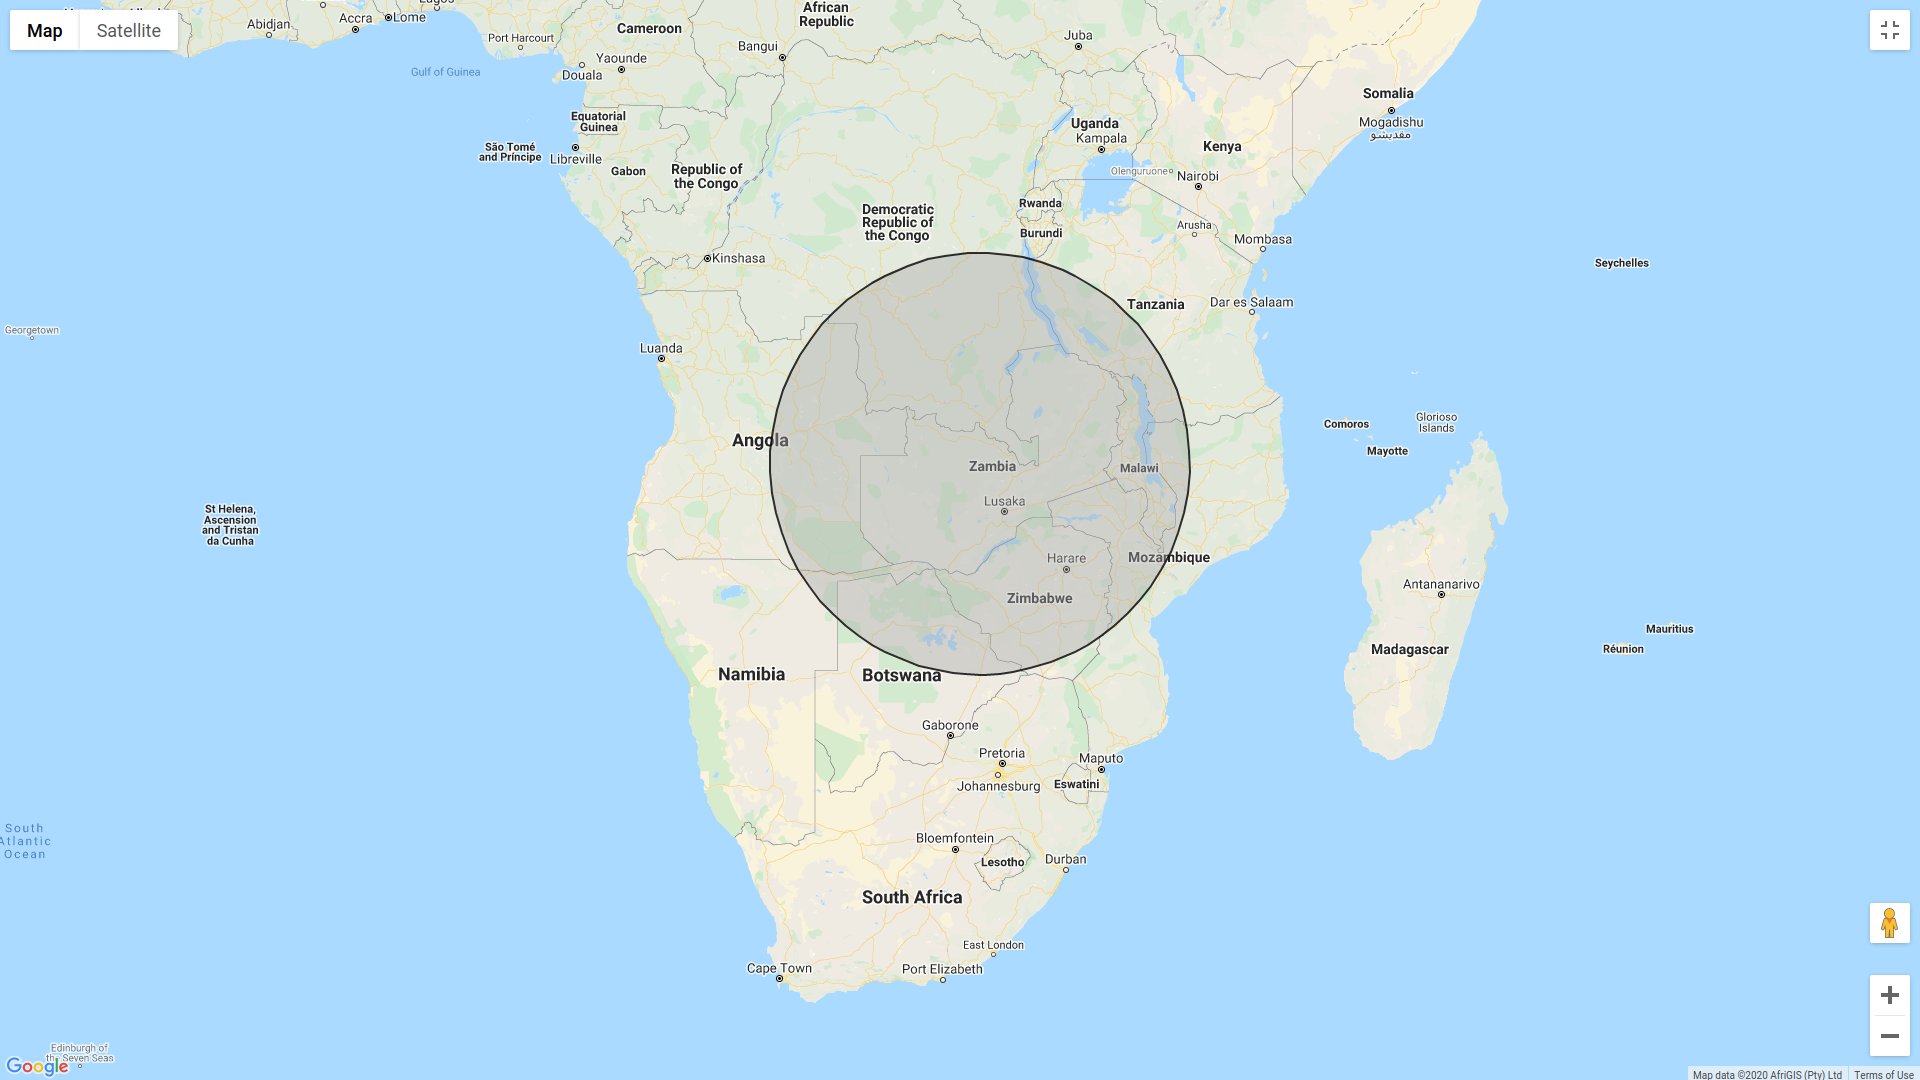

In [ ]:
# ___Cell no. 23___

search_words = "coronavirus OR covid OR pandemic OR covid19 OR lockdown"

# Latitude, logitude and search radius(km) for Zambia and some surrounding regions
loc = "-13.1884925,27.2397481,1000km"

# Search dates
date_since = "2020-09-25"
date_until = "2020-09-27"

# We also want to exclude retweets and replies as this may sway results
my_search = search_words + " -filter:retweets" + " -filter:replies"  

In [ ]:
# ___Cell no. 24___

# Use the tweepy Cursor method to access tweets from a specified region and between certain dates
tweets = tweepy.Cursor(api.search,
                       q=my_search,
                       lang="en",
                       tweet_mode='extended',
                       geocode=loc,
                       since=date_since,
                       until=date_until).items(1000)

In [ ]:
%%time

# ___Cell no. 25___

# Once again, this should take ~2 minutes to run if you are collecting 1000 tweets
tweet_info = [[tweet.id_str,tweet.created_at,tweet.user.location,tweet.full_text] for tweet in tweets]

# Put our data into a dataframe 
df_new = pd.DataFrame(data=tweet_info, columns=['tweet_id_str','date_time','location','tweet_text'])

# Have a quick look at the dataframe
df_new

We see that the search region specified in our query is correct and that location information is now available for each tweet.

**Additional challenge**: Try out a few queries of your own! Perhaps search for tweets around topics you're interested in and see what comes up. Feel free to collect tweets for a specific country/region as well. 

<div class="alert alert-block alert-info">
    
<b>Note:</b> Do NOT excdeed 1000 tweets per query, as it is likely that you will then be rate-limited by the Twitter API. However, you are able to run multiple queries.

</div>

After completing this tutorial you should be able to:

- Collect tweets related to a given topic / search words
- Access the respective metadata for each tweet
- Collect tweets from any region in the world
- Clean text
- Convert text to lower case
- Remove stop words from the text

### Tutorial 1 complete! Well done! 